In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
!wget --no-check-certificate -o bank+marketing.zip "https://archive.ics.uci.edu/static/public/222/bank+marketing.zip"

In [3]:
!unzip -o bank+marketing.zip
!unzip -o bank.zip

df = pd.read_csv('bank-full.csv', delimiter=";")

Archive:  bank+marketing.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of bank+marketing.zip or
        bank+marketing.zip.zip, and cannot find bank+marketing.zip.ZIP, period.
Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [4]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [5]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
features = [
    'age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day',
    'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y'
]

df = df[features]
df['y'] = (df.y == 'yes').astype(int)

In [17]:
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

In [18]:
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,0


In [19]:
numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

from sklearn.metrics import roc_auc_score

scores = []

for C in numerical:
    auc_score = roc_auc_score(y_train, df_train[C])
    if auc_score < 0.5:
        auc_score = roc_auc_score(y_train, -df_train[C])
    scores.append(auc_score)
    print('%16s, %.3f' %(C, auc_score))


             age, 0.512
         balance, 0.589
             day, 0.526
        duration, 0.815
        campaign, 0.571
           pdays, 0.590
        previous, 0.599


In [24]:
categorical = list(df_train.drop(numerical, axis=1).columns)
categorical

['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

In [25]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [26]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:,1]
y_pred = (y_pred >= 0.5).astype(int)

In [32]:
auc = roc_auc_score(y_val, y_pred)
auc = round(auc, 3)
auc

0.658

In [40]:
!pip install tqdm
from tqdm.auto import tqdm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [41]:
thresholds = np.arange(0, 1, 0.01)
y_pred = model.predict_proba(X_val)[:,1]
precision = []
recall = []

for t in thresholds:
    y_pred_pos = (y_pred >= t)
    y_pred_neg = (y_pred < t)
    y_act_pos = (y_val == 1)
    y_act_neg = (y_val == 0)

    tp = (y_pred_pos & y_act_pos).sum()
    fp = (y_pred_pos & y_act_neg).sum()
    tn = (y_pred_neg & y_act_neg).sum()
    fn = (y_pred_neg & y_act_pos).sum()

    precision.append(tp/(tp+fp))
    recall.append(tp/(tp+fn))

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

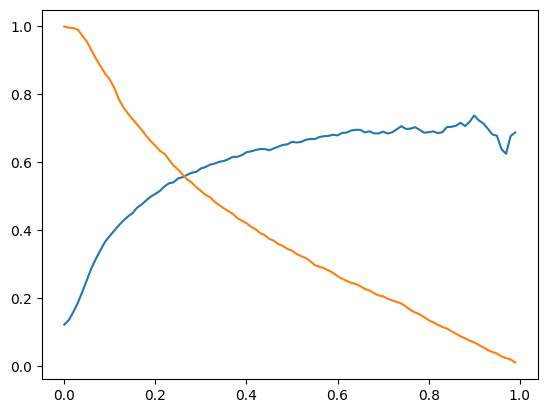

In [42]:
plt.figure()
plt.plot(thresholds, precision, label='precsision')
plt.plot(thresholds, recall, label='recall')
plt.legend